Pancreas ductal vs. endocrine maturation 
----
In the main analysis of Fig. 2 and 3, we focus on endocrine maturation, i.e. the process that leads to the hormone-producing alpha, beta, epsilon and delta cells, see for example [Bastidas-Ponce et al., Development 2017](https://pubmed.ncbi.nlm.nih.gov/28811309/). Here, we show how CellRank can be used to delineate the signatures of ductal vs. endocrine maturation. 

# Preliminaries

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.5.0+g65f1562 scanpy==1.8.1 anndata==0.7.6 numpy==1.20.3 numba==0.54.0 scipy==1.7.1 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.13.0rc0 python-igraph==0.9.1 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.4.3 seaborn==0.11.2


In [3]:
cr.logging.print_version_and_date()

Running CellRank 1.5.0+g65f1562, on 2021-10-26 15:02.


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [4]:
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

In [5]:
# we're only using one directly here, so can save some text
FIG_DIR = FIG_DIR / "suppl_figures_pancreas" / "suppl_fig_proliferation"

Set up the paths to save figures.

In [6]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [7]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "pancreas", separate_dirs=True)
    print('Sucessfully imported scachepy. Expensive computations will be cached. ')
except ImportError:
    print('Failed to import scachepy. Consider installing it from `https://github.com/theislab/scachepy`. ')
    c = None
    
use_caching = c is not None
c

Sucessfully imported scachepy. Expensive computations will be cached. 


Cache(root=/Users/marius/Projects/cellrank_reproducibility_2/cache/pancreas, ext='.pickle', compression='None')

## Set global parameters

Set some plotting parameters.

In [8]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [9]:
# should figures just be displayed or also saved?
save_figure = True

# should cashed values be used, or recompute?
force_recompute = False

If there are other global parameters for this analysis, put them here as well. 

## Load the data

Download the pancreas data, including ductal cells, from [scVelo](https://scvelo.readthedocs.io/) by running `scv.datasets.pancreas()`. 

In [10]:
adata = scv.read(DATA_DIR / "pancreas" / "pancreas_ductal_endocrine.h5ad")
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

# Quality control and pre-processing

## Pre-process the data

Often, we want to process the raw data a bit differently than the data in `.X`.

### Raw data (for plotting)

In [11]:
adata_raw = adata.copy()
sc.pp.filter_genes(adata_raw, min_cells=10)
scv.pp.normalize_per_cell(adata_raw)
sc.pp.log1p(adata_raw)

# annotate highly variable genes, but don't filter them out
sc.pp.highly_variable_genes(adata_raw)
print(f"This detected {np.sum(adata_raw.var['highly_variable'])} highly variable genes. ")
adata.raw = adata_raw

filtered out 14177 genes that are detected in less than 10 cells
Normalized count data: X, spliced, unspliced.
extracting highly variable genes
    finished (0:00:00)
This detected 1789 highly variable genes. 


### Data for velocity computation

In [12]:
# filter, normalise, log transform
scv.pp.filter_and_normalize(adata, min_shared_counts=20, log=True, n_top_genes=2000)

# compute pca, knn graph and scvelo's moments
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:02)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Compute and visualise velocities using scVelo

## Visualize annotations

Show proliferation signature:

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_pancreas/suppl_fig_proliferation/umap_cell_cycle_scores.pdf


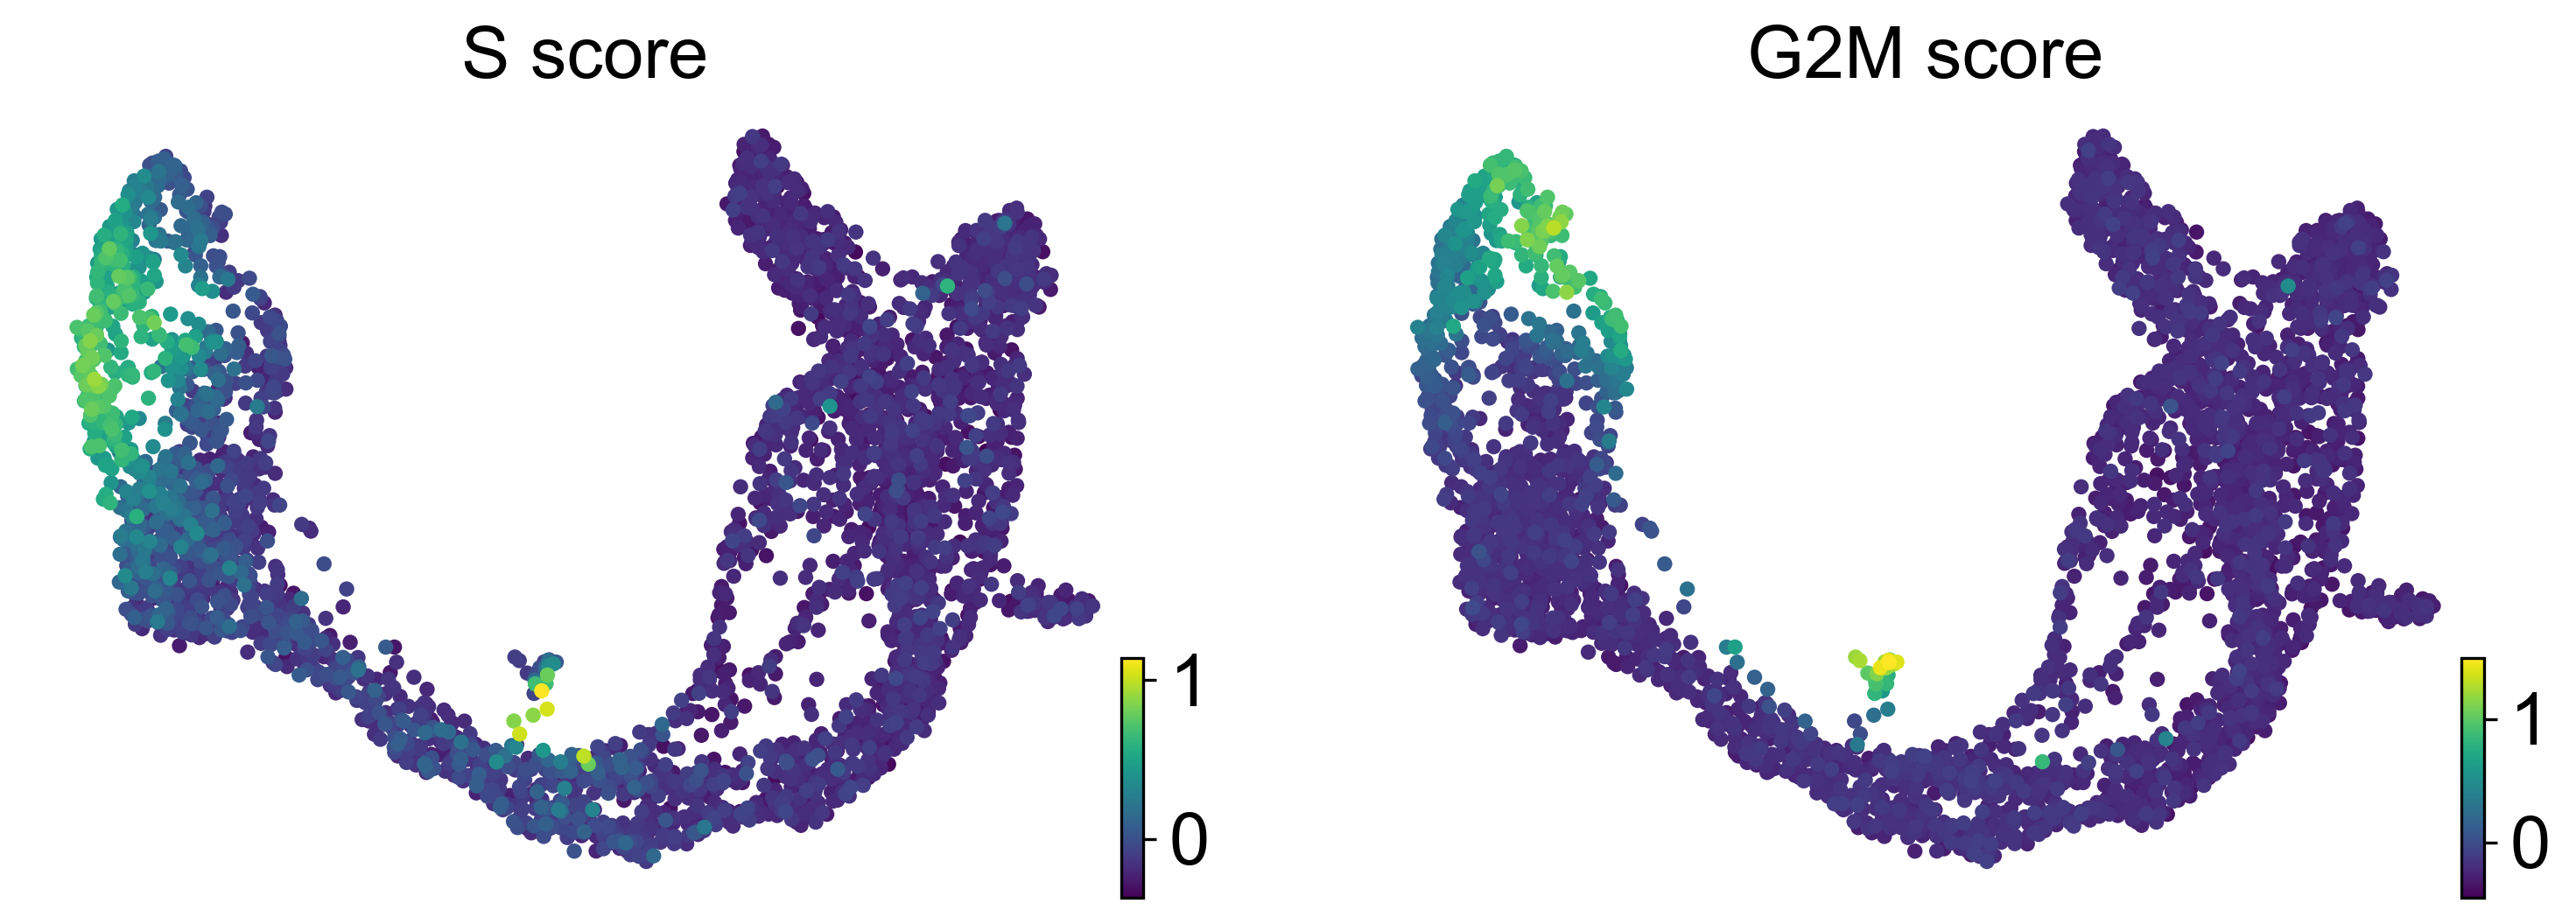

In [13]:
scv.pl.scatter(adata, c=['S_score', 'G2M_score'], s=70, dpi=150, perc=[0, 100], 
               save="umap_cell_cycle_scores.pdf" if save_figure else None)

## Compute velocities using scVelo

In [14]:
# compute/load from cache the dyn. model params and compute velocities
n_jobs=8

if use_caching:
    c.tl.recover_dynamics(adata, fname='2021-09-22_recover_dynamics_ductal_vs_endocrine', force=force_recompute, 
                          n_jobs=n_jobs)
else:
    scv.tl.recover_dynamics(adata)
    
scv.tl.velocity(adata, mode='dynamical', n_jobs=n_jobs)

Loading data from: `2021-09-22_recover_dynamics_ductal_vs_endocrine.pickle`.
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Project velocities onto the embedding

Show velocities in UMAP. 

computing velocity graph (using 8/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_pancreas/suppl_fig_proliferation/umap_velocities.png


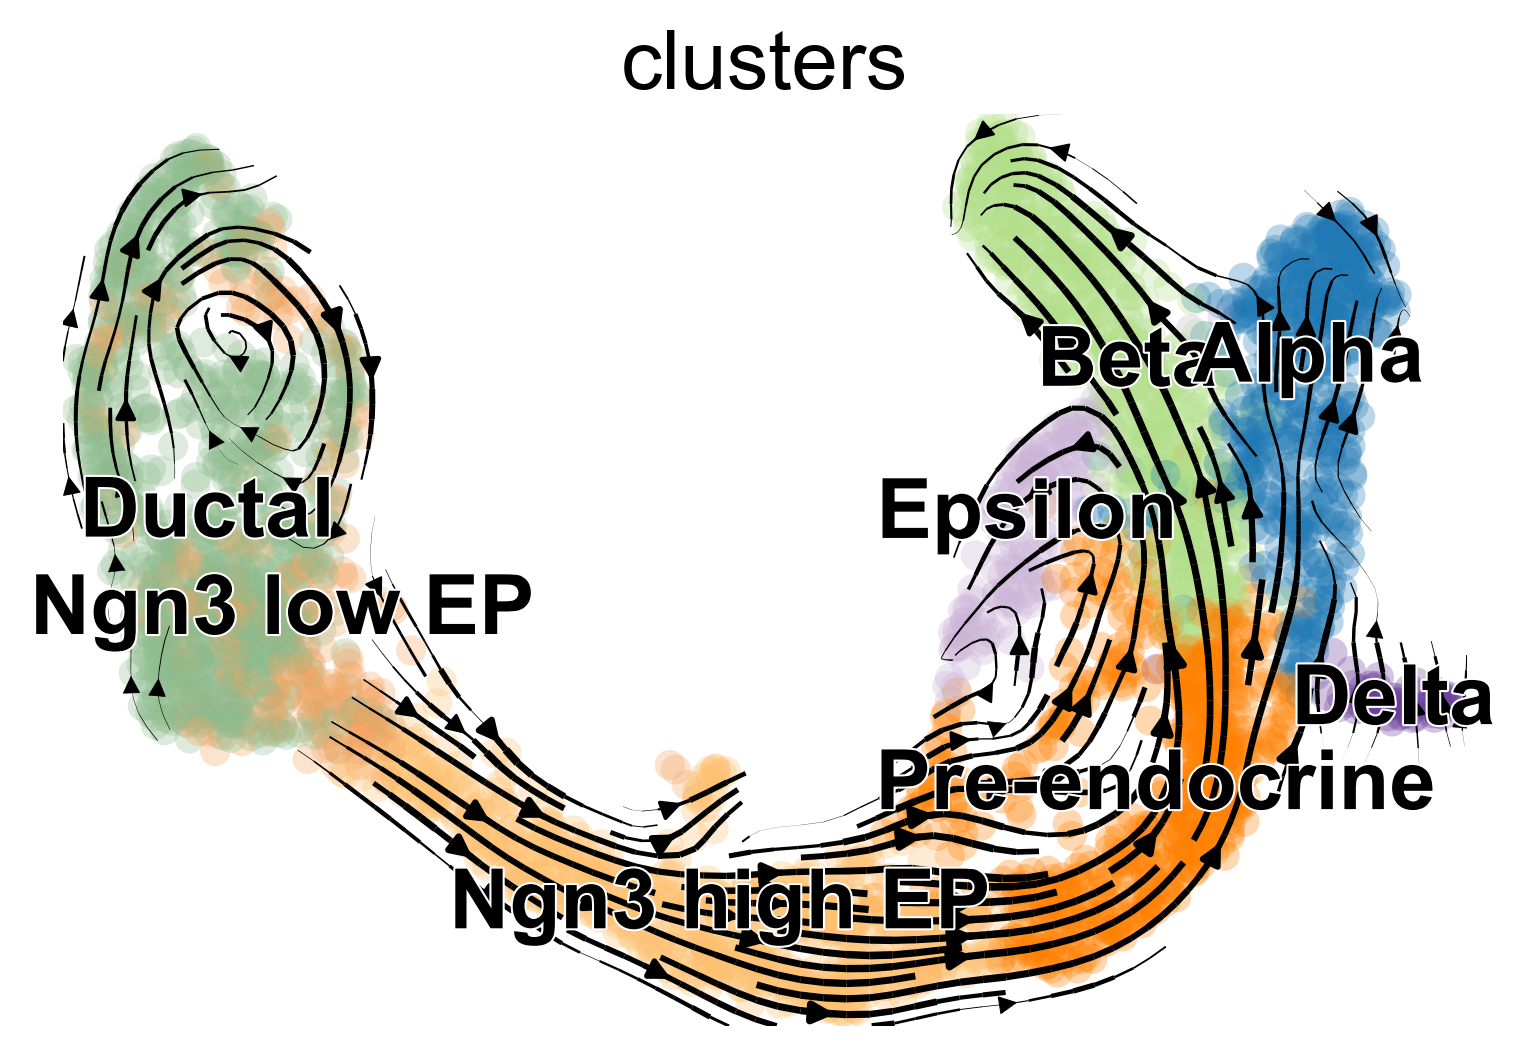

In [15]:
scv.tl.velocity_graph(adata, n_jobs=8)
scv.pl.velocity_embedding_stream(adata, dpi=150, save="umap_velocities.pdf" if save_figure else None )

# CellRank analysis

## Initialise kernel and estimator

This serves as an example of how to cach a transition matrix and of the default values we should be using. 

In [16]:
from cellrank.tl.estimators import GPCCA

# set the parameters we want to use to compute the transition matrix
weight_connectivities=0.2
mode="stochastic" 
n_jobs=8
softmax_scale=None

if use_caching:
    c.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode=mode, 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale, 
                           fname=f"2021-09-22_transition_matrix_{mode}_ductal_vs_endocrine", 
                           force=force_recompute)
    g_fwd = GPCCA(adata, obsp_key='T_fwd')
else:
    kernel = cr.tl.transition_matrix(adata, 
                                     weight_connectivities=weight_connectivities, 
                                     mode=mode, 
                                     n_jobs=n_jobs, 
                                     softmax_scale=softmax_scale)
    g_fwd = GPCCA(kernel)
    
print(g_fwd)

Loading data from: `2021-09-22_transition_matrix_stochastic_ductal_vs_endocrine.pickle`.
GPCCA[n=3696, kernel=<PrecomputedKernel[origin=adata.obsp['T_fwd']]>]


## Print transition matrix statistics for reproducibility

To make sure that we're using the same transition matrix, show some stats. 

In [17]:
# just for consistency, display some summary staes about the transition matrix
T = adata.obsp['T_fwd']
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.018122,
mean = 0.024749,
var = 0.000598,
min = 0.000019,
max = 0.404272


## Compute the real Schur decomposition

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 8]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


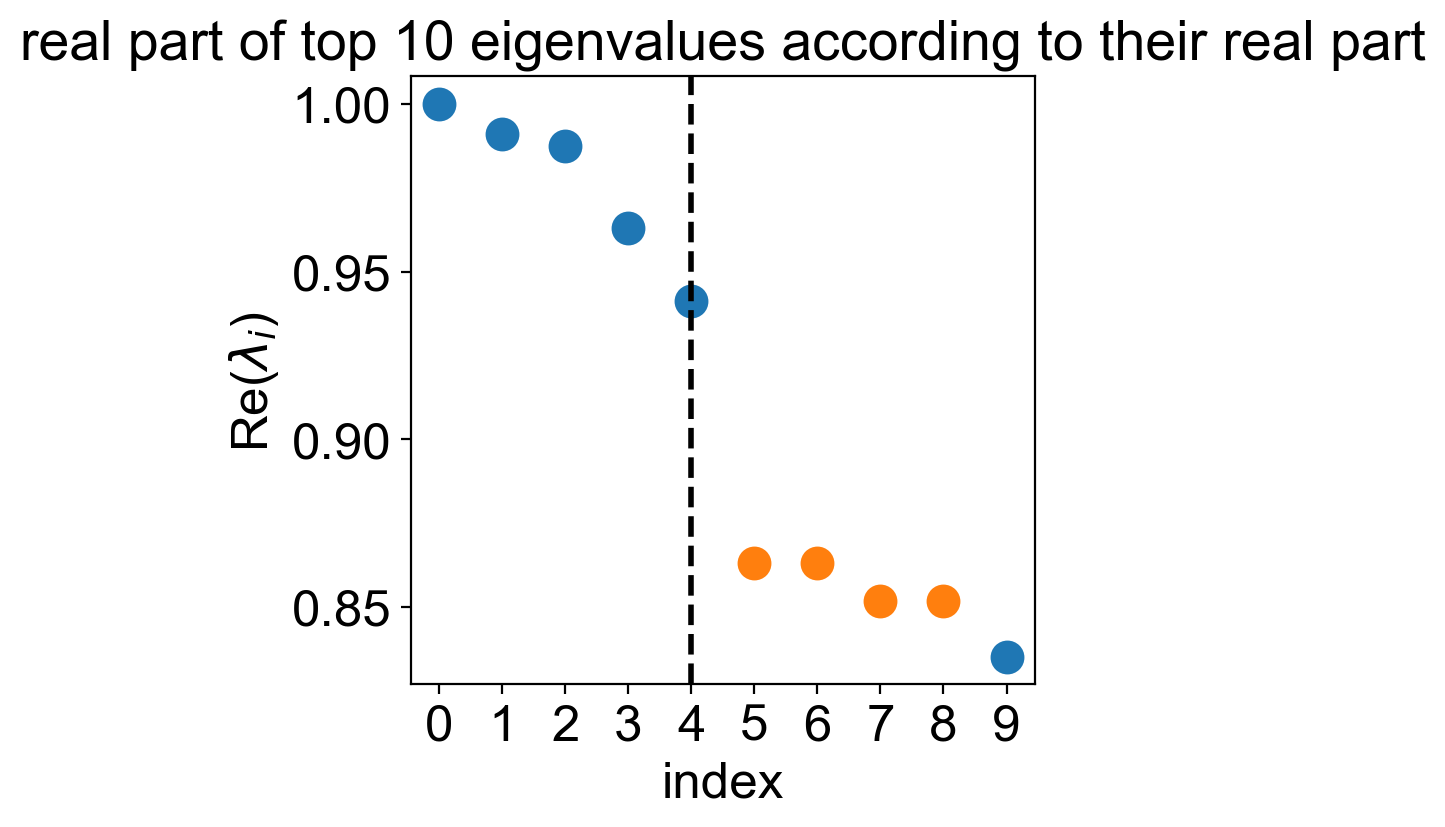

In [18]:
g_fwd.compute_schur()
g_fwd.plot_spectrum(real_only=True, s=500, legend_loc="none", figsize=(4, 4), 
                    save='spectrum.pdf' if save_figure else None)

## Compute macrostates

Computing `5` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_pancreas/suppl_fig_proliferation/umap_macrostates.pdf


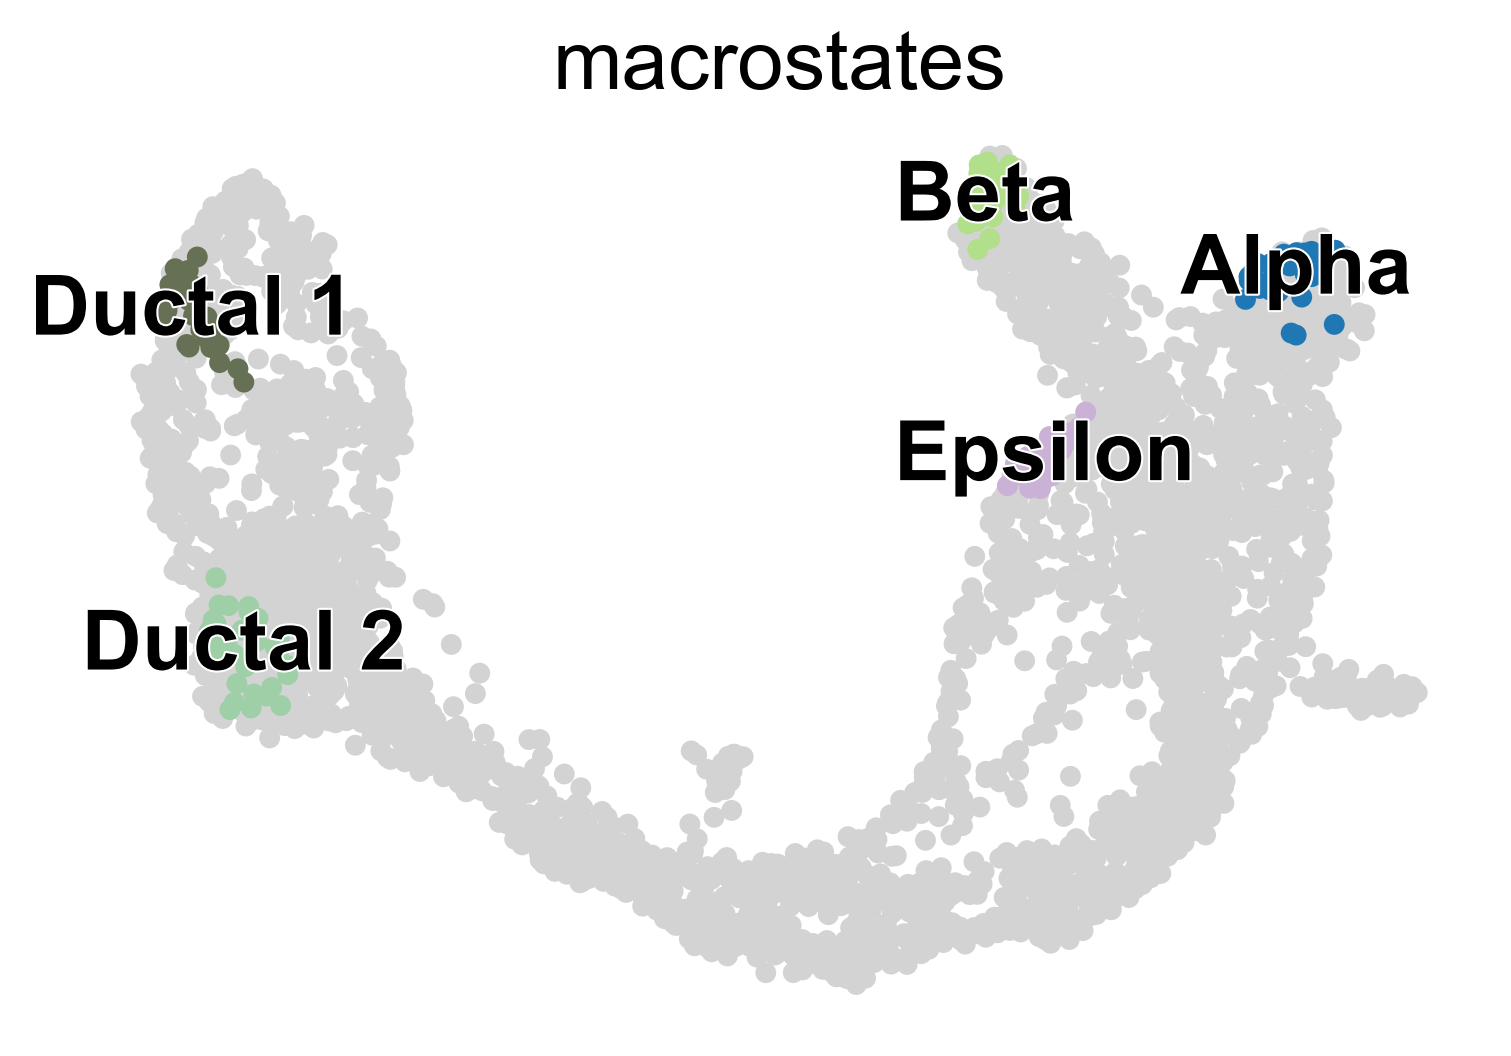

In [19]:
g_fwd.compute_macrostates(cluster_key='clusters', n_states=5)
g_fwd.plot_macrostates(discrete=True, legend_loc='on data', size=100, dpi=150, 
                       save='umap_macrostates.pdf' if save_figure else None)

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


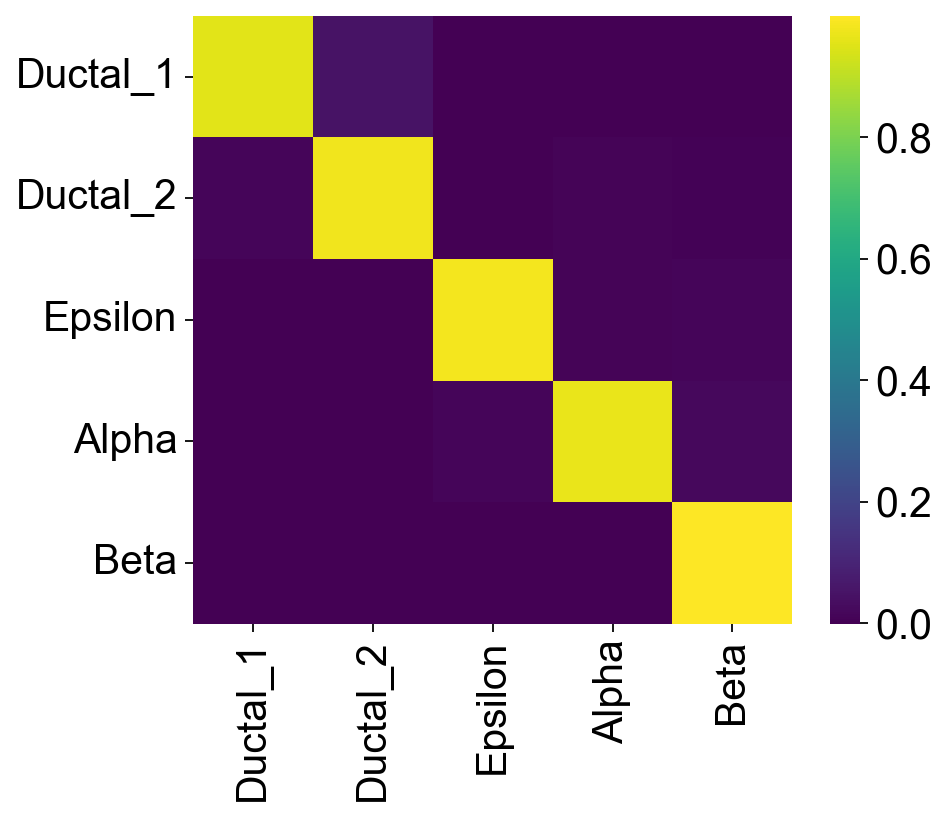

In [20]:
T_coarse = g_fwd.coarse_T
macro_names = ['Ductal_1', 'Ductal_2', 'Epsilon', 'Alpha', 'Beta']

fig = plt.figure(None, (6, 5))
ax = fig.add_subplot(111)
sns.heatmap(T_coarse[macro_names].loc[macro_names], cmap='viridis', ax=ax, annot=False, fmt='.2f')

if save_figure:
    plt.savefig(FIG_DIR / "trans_mat_coarse.pdf", bbox_inches='tight')

plt.show()

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


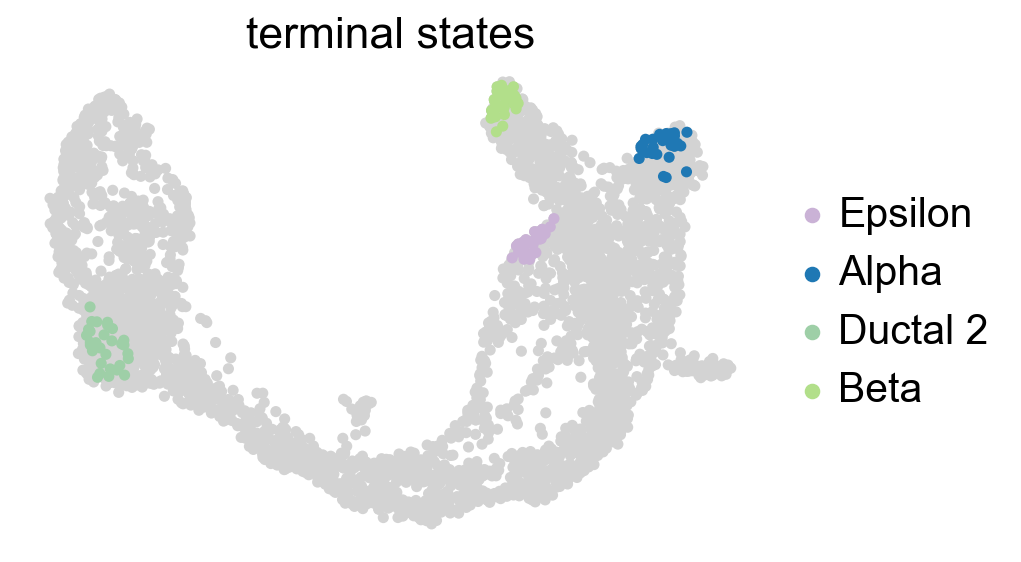

In [21]:
g_fwd.compute_terminal_states()
g_fwd.plot_terminal_states(discrete=True, legend_loc='right', size=100)

## Compute fate probabilities towards the terminal states

Computing absorption probabilities


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/2 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)
saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_pancreas/suppl_fig_proliferation/umap_fate_probabilities.pdf


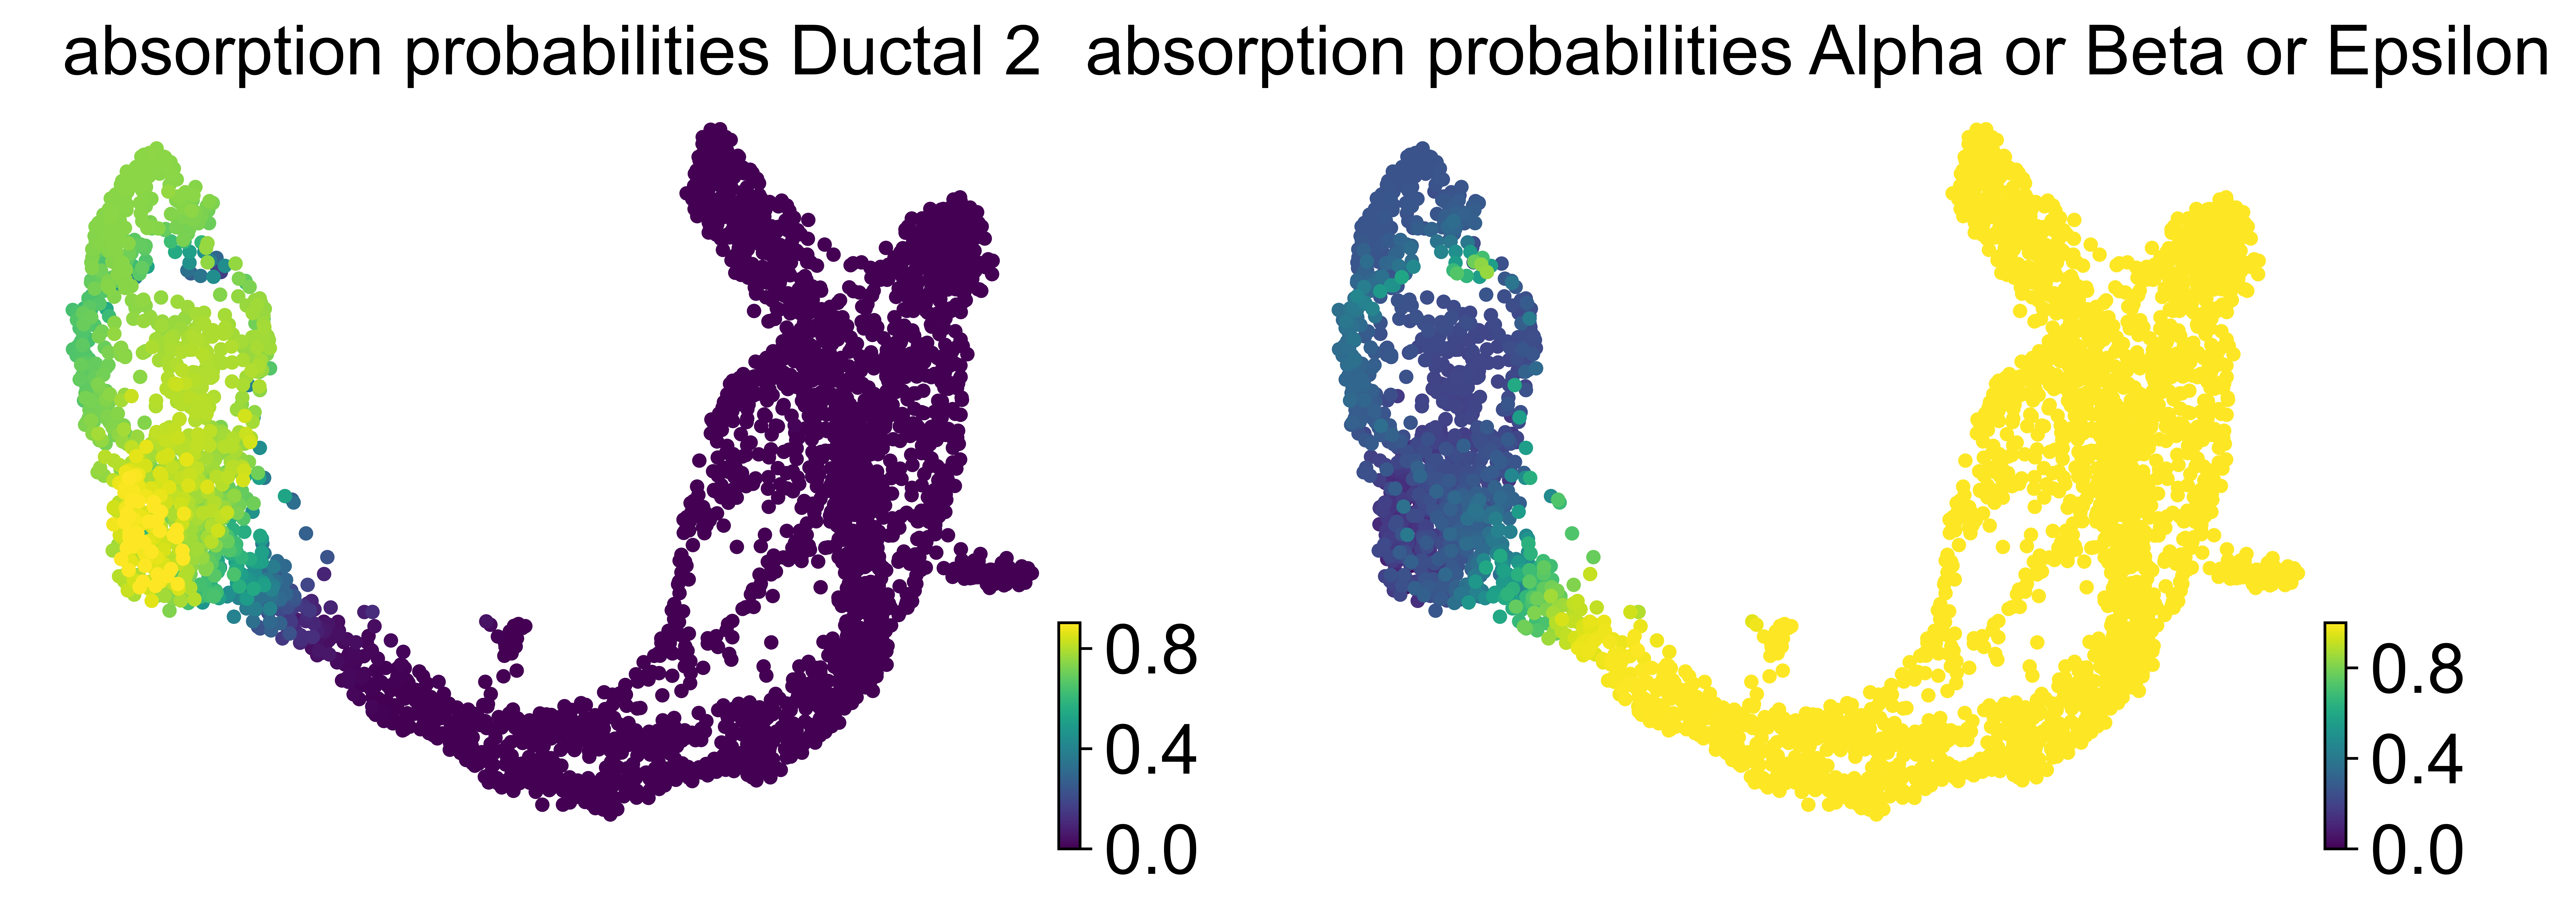

In [22]:
g_fwd.compute_absorption_probabilities(keys=['Epsilon, Alpha, Beta', 'Ductal_2'])
g_fwd.plot_absorption_probabilities(same_plot=False, size=70, dpi=500, 
                                    save="umap_fate_probabilities.pdf" if save_figure else None)

## Look into lineage drivers

Compute lineage drivers, restricted to the Ductal and Ngn3 low EP clusters:

In [23]:
ld_df = g_fwd.compute_lineage_drivers(clusters=['Ductal', 'Ngn3 low EP'], cluster_key='clusters', return_drivers=False, 
                              use_raw=True)
ld_df.head(5)

Adding `adata.raw.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ductal_2_corr  Ductal_2_pval  Ductal_2_qval  Ductal_2_ci_low  \
index                                                                   
Lurap1l       0.459084   7.268318e-65            NaN         0.412792   
Atp1b1        0.358750   6.656695e-38            NaN         0.307944   
Krt19         0.357934   1.008197e-37            NaN         0.307096   
Nudt19        0.357873   1.039919e-37            NaN         0.307033   
Jun           0.314602   6.219774e-29            NaN         0.262197   

         Ductal_2_ci_high  Alpha or Beta or Epsilon_corr  \
index                                                      
Lurap1l          0.503010                      -0.459085   
Atp1b1           0.407516                      -0.358752   
Krt19            0.406735                      -0.357934   
Nudt19           0.406676                      -0.357873   
Jun              0.365156                      -0.314601   

         Alpha or Beta or Epsilon_pval  Alpha or Beta or Epsilon_qval  \
index                                                                   
Lurap1l                   7.260169e-65                            NaN   
Atp1b1                    6.650961e-38                            NaN   
Krt19                     1.008287e-37                            NaN   
Nudt19                    1.040155e-37                            NaN   
Jun                       6.220298e-29                            NaN   

         Alpha or Beta or Epsilon_ci_low  Alpha or Beta or Epsilon_ci_high  
index                                                                       
Lurap1l                        -0.503012                         -0.412793  
Atp1b1                         -0.407518                         -0.307946  
Krt19                          -0.406734                         -0.307096  
Nudt19                         -0.406676                         -0.307033  
Jun                            -0.365156                         -0.262197

Differentiation towards endocrine populations:

In [24]:
# define endocrine and ductal markers
endocrine_markers = ['Neurog3', 'Insm1']
ductal_markers = ['Sox9']

assert all([gene in adata_raw.var.index for gene in ductal_markers]), "Some genes are missing from AnnData"
assert(all([gene in adata_raw.var.index for gene in endocrine_markers])), "Some genes are missing from AnnData"

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Check where endocrine markers rank:

In [25]:
endocrine_corr_df = ld_df.sort_values(by='Alpha or Beta or Epsilon_corr', ascending=False)
endocrine_corr_df['rank'] = range(endocrine_corr_df.shape[0])
{gene: endocrine_corr_df.loc[gene, 'rank'] for gene in endocrine_markers}

{'Neurog3': 0, 'Insm1': 5}

Plot Ngn3 expression:

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_pancreas/suppl_fig_proliferation/umap_ngn3.pdf


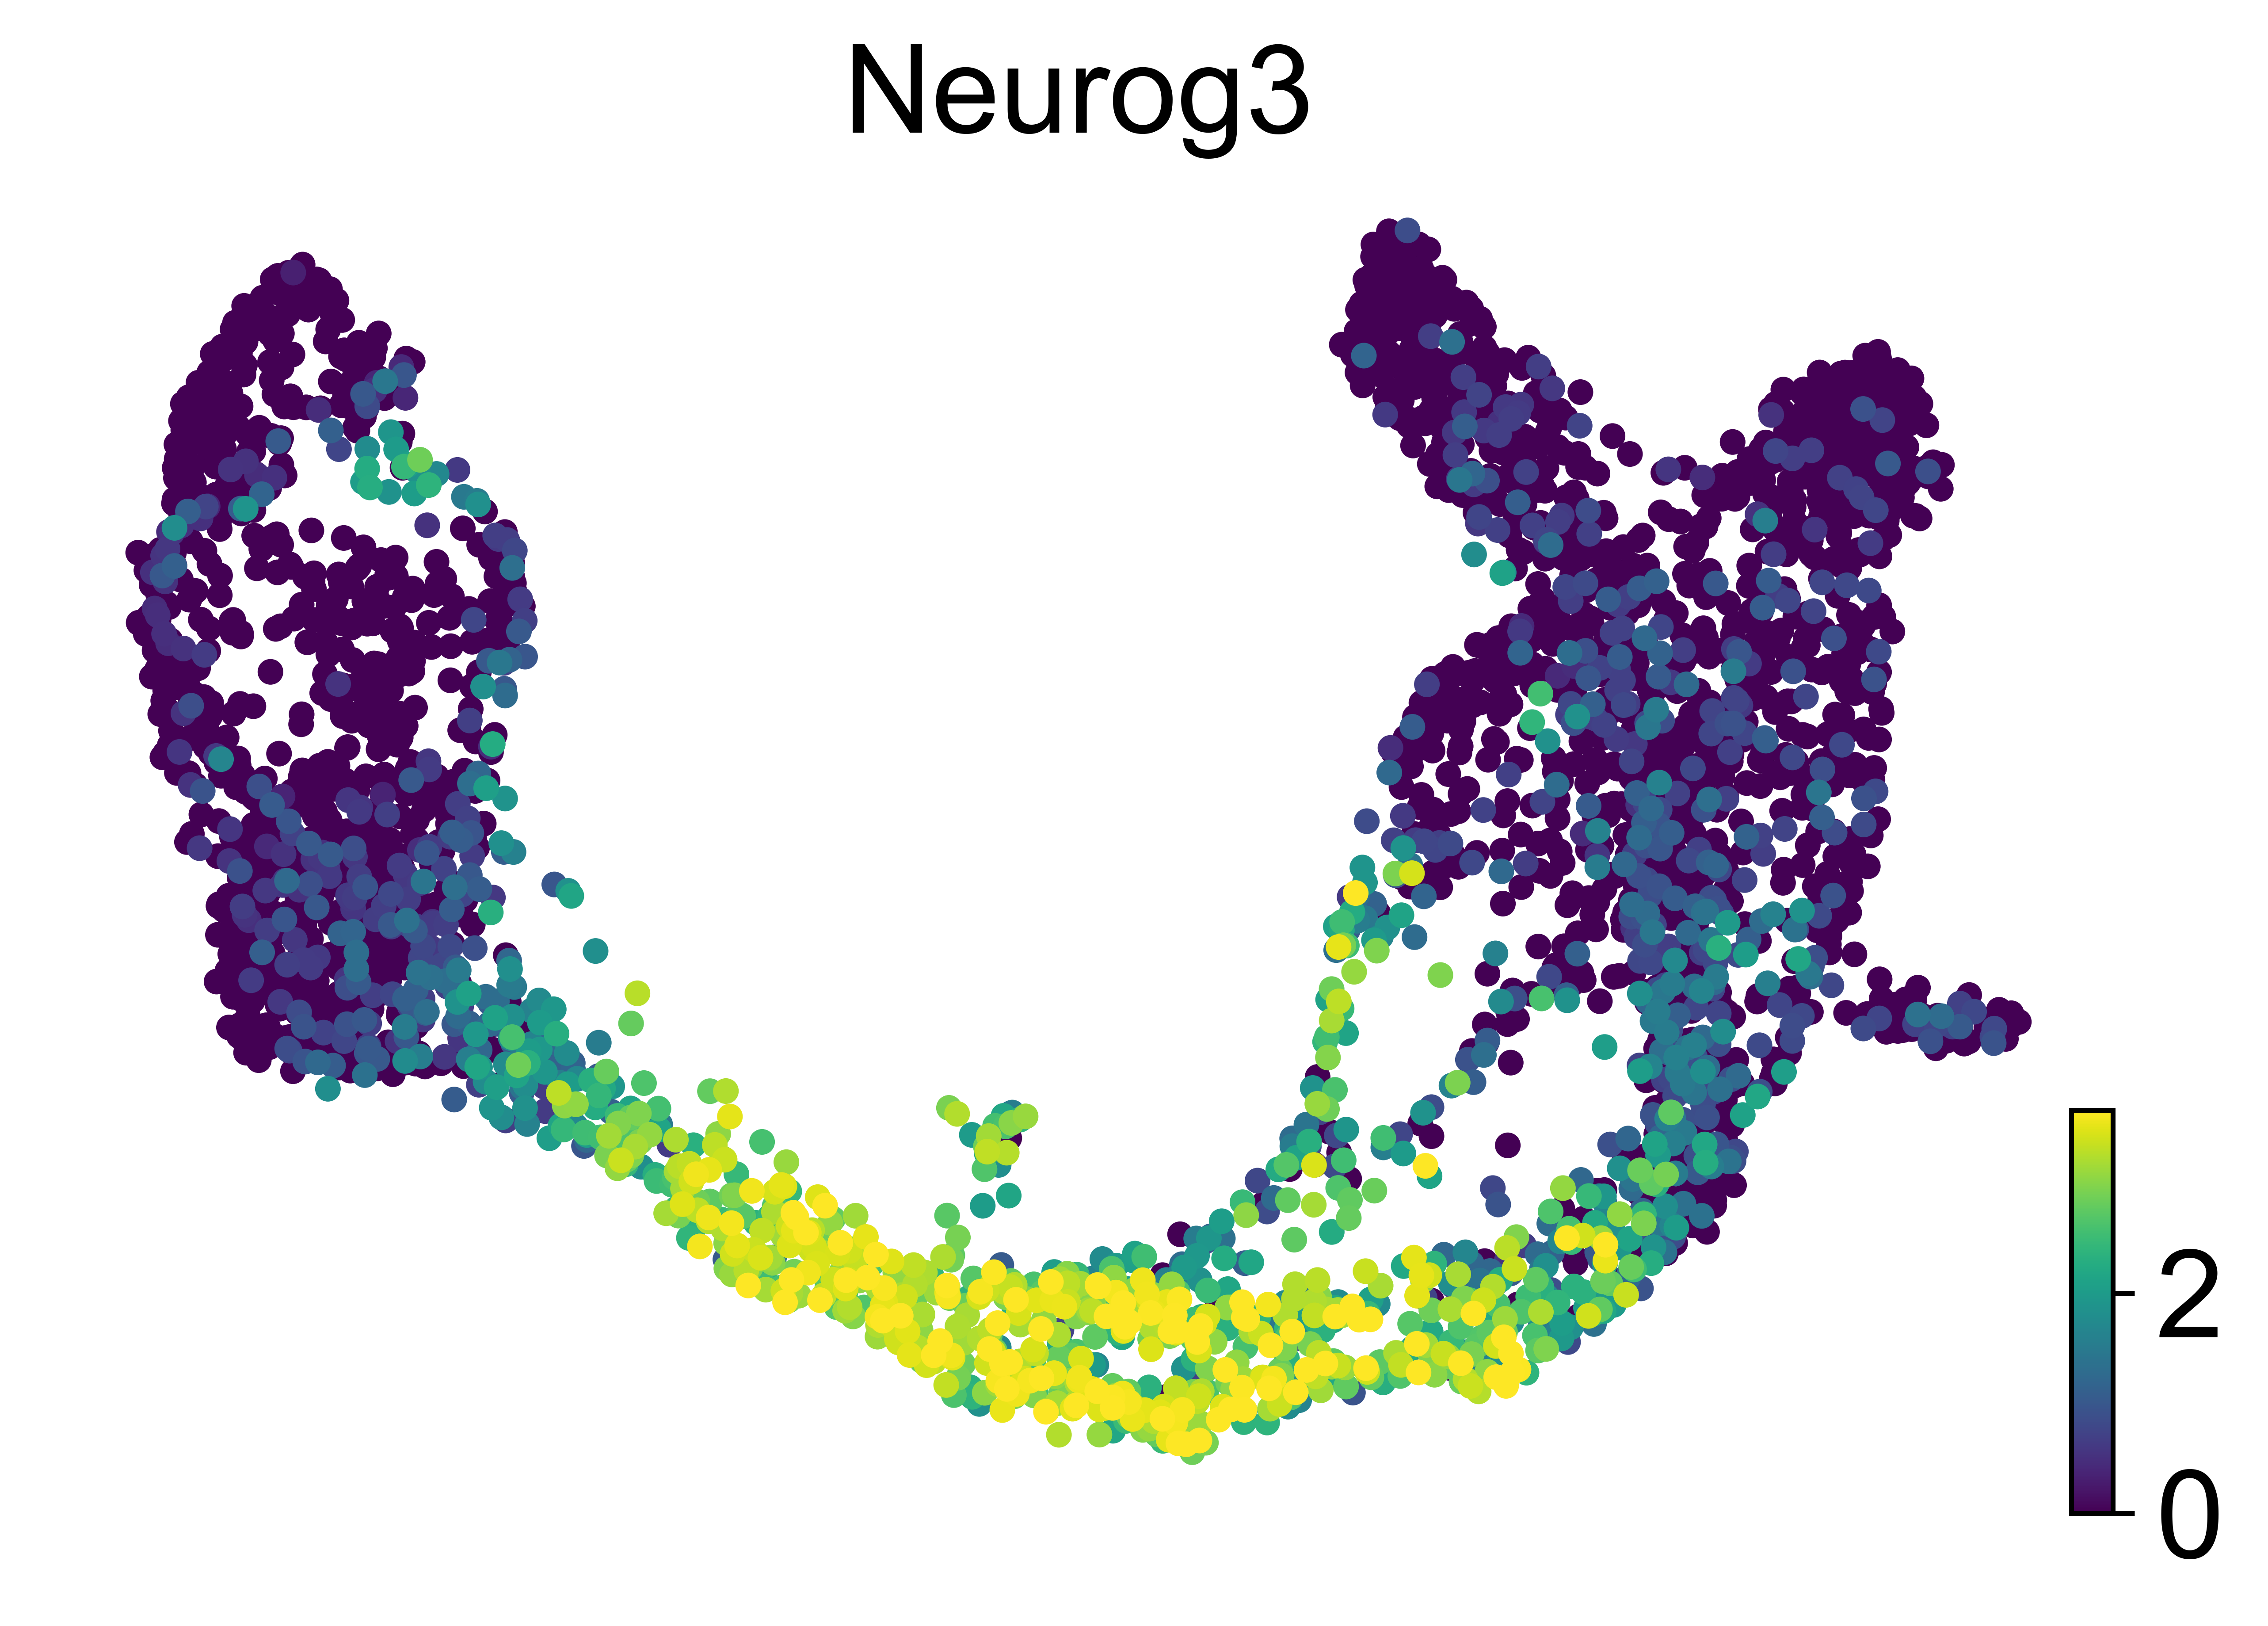

In [26]:
scv.pl.scatter(adata_raw, c='Neurog3', s=70, dpi=500, perc=[0, 98], 
               save="umap_ngn3.pdf" if save_figure else None)

Check for the correlction of Ngn3 with endocrne fate probabilities:

In [27]:
print(f"Corrleation between Ngn3 and endocrine fate probability:",
      f"{endocrine_corr_df.loc['Neurog3', 'Alpha or Beta or Epsilon_corr']:.2f}.")

Corrleation between Ngn3 and endocrine fate probability: 0.66.


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Check where ductal markers rank:

In [28]:
ductal_corr_df = ld_df.sort_values(by='Ductal_2_corr', ascending=False)
ductal_corr_df['rank'] = range(ductal_corr_df.shape[0])
{gene: ductal_corr_df.loc[gene, 'rank'] for gene in ductal_markers}

{'Sox9': 21}